#### **imports**

In [20]:
import pickle
import sys
import torch
import torch.nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid

# Traditional
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

# Tree-Based
from sksurv.ensemble import RandomSurvivalForest

# NN
from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from auton_survival.models.dsm import DeepSurvivalMachines
import torchtuples as tt

# Evaluation
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

# Add the outer directory
sys.path.append('../')
from eval_surv_copy import EvalSurv

#### **Load Data**

In [84]:
# Read the pickled DataFrames
with open('data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)


# Read the pickled DataFrame
with open('data/consolidated_pat_tbl.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

#### **Non-Param**

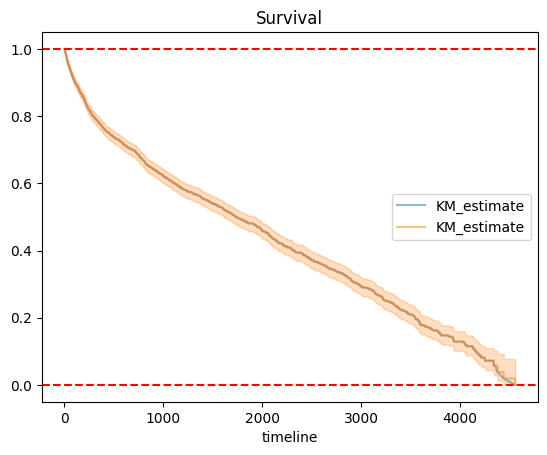

In [3]:
kmf = KaplanMeierFitter()

T = x_train["time_to_event"]
E = x_train["death"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot(alpha = 0.5)

plt.title('Survival');

kmf.plot_survival_function(alpha = 0.5);

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

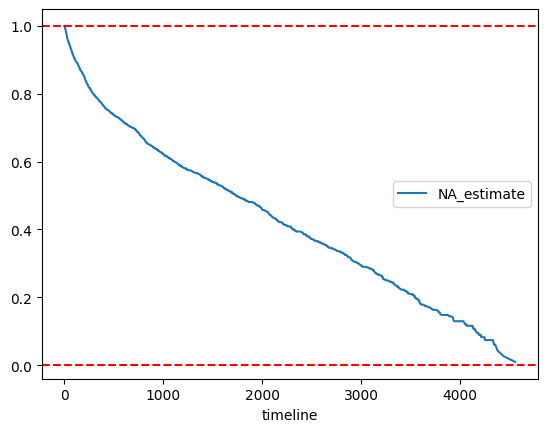

In [4]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

#### **Semi-Param**

In [5]:
cph = CoxPHFitter(penalizer = 0.01)
cph.fit(x_train, duration_col='time_to_event', event_col='death', fit_options = {'step_size':0.1})
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4138 total observations, 2744 right-censored observations>
             duration col = 'time_to_event'
                event col = 'death'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4138
number of events observed = 1394
   partial log-likelihood = -9644.34
         time fit was run = 2023-07-18 06:07:56 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
cholesterol   -0.10       0.91       0.03            -0.15            -0.04                 0.86                 0.96
sodium        -0.04       0.96       0.03            -0.10             0.01                 0.90                 1.01
lymphocyte    -0.04       0.96       0.03            -0.10             0.02                 0.90                 1.02
hemoglobin    -0.42       0.66       0.03            -0.49            -0.35                 0.62                 0.70
temperature   -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
heartrate      0.09       1.09       0.03             0.02             0.15                 1.02                 1.16
resprate       0.10       1.11       0.03             0.05             0.16                 1.05                 1.18
o2sat         -0.20       0.82       0.06            -0.32            -0.08                 0.72                 0.92
sbp           -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
dbp            0.01       1.01       0.05            -0.08             0.10                 0.92                 1.10
acebutolol    -0.00       1.00       0.14            -0.28             0.28                 0.75                 1.32
amlodipine    -0.09       0.92       0.03            -0.14            -0.03                 0.87                 0.97
atenolol       0.04       1.04       0.02             0.00             0.09                 1.00                 1.09
benazepril    -0.02       0.98       0.02            -0.07             0.03                 0.94                 1.03
candesartan    0.01       1.01       0.02            -0.02             0.04                 0.98                 1.04
captopril     -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
diltiazem     -0.02       0.98       0.02            -0.07             0.02                 0.94                 1.02
felodipine    -0.04       0.96       0.03            -0.11             0.02                 0.90                 1.02
irbesartan     0.02       1.02       0.02            -0.03             0.06                 0.97                 1.07
lisinopril    -0.06       0.94       0.03            -0.12            -0.01                 0.89                 0.99
moexipril     -0.03       0.97       0.03            -0.09             0.03                 0.92                 1.03
nadolol       -0.02       0.98       0.02            -0.06             0.03                 0.94                 1.03
nebivolol     -0.06       0.94       0.08            -0.23             0.10                 0.80                 1.11
nicardipine   -0.05       0.96       0.06            -0.17             0.08                 0.84                 1.08
nifedipine     0.02       1.02       0.02            -0.02             0.05                 0.98                 1.06
olmesartan    -0.02       0.98       0.07            -0.15             0.11                 0.86                 1.12
propranolol   -0.01       0.99       0.02            -0.05             0.03                 0.95                 1.03
quinapril     -0.03       0.97       0.02            -0.07             0.02                 0.93                 1.02
ramipril       0.04     

<Axes: >

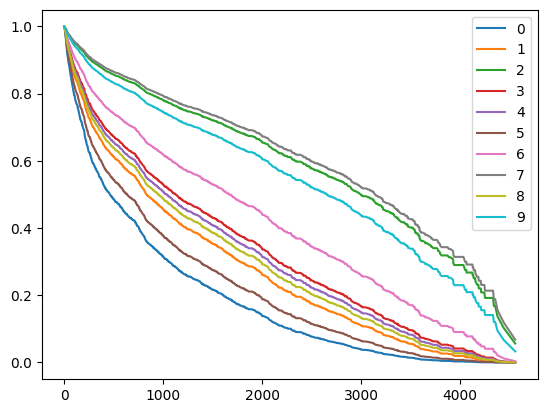

In [6]:
cph.predict_survival_function(x_test.iloc[:10]).plot()

#### **Param**

In [7]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01)
eps = 1e-8
x_train['time_to_event'] = x_train['time_to_event'] + eps
aft.fit(x_train, duration_col='time_to_event', event_col='death')

aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 4138 total observations, 2744 right-censored observations>
             duration col = 'time_to_event'
                event col = 'death'
                penalizer = 0.01
   number of observations = 4138
number of events observed = 1394
           log-likelihood = -11868.426
         time fit was run = 2023-07-18 06:07:59 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                            
lambda_ 0            -0.113      0.893      0.292           -0.685            0.458                0.504                1.581
        1             0.282      1.326      0.233           -0.174            0.738                0.841                2.092
        2             0.409      1.505      0.270           -0.121            0.939                0.886                2.557
        3            -0.389      0.678      0.560           -1.487            0.708                0.226                2.031
        4            -0.374      0.688      0.266           -0.896            0.147                0.408                1.158
        5            -0.188      0.829      0.228           -0.634            0.259                0.530                1.295
        acebutolol    0.006      1.006      0.135           -0.259            0.271                0.772                1.311
        amlodipine    0.091      1.096      0.031            0.031            0.152                1.031                1.164
        atenolol     -0.048      0.953      0.026           -0.099            0.004                0.905                1.004
        benazepril    0.024      1.024      0.028           -0.030            0.078                0.970                1.081
        candesartan  -0.005      0.995      0.018           -0.041            0.030                0.960                1.031
        captopril     0.014      1.014      0.019           -0.024            0.052                0.977                1.053
        cholesterol   0.097      1.102      0.033            0.033            0.161                1.034                1.175
        dbp          -0.015      0.985      0.053           -0.119            0.088                0.888                1.092
        diltiazem     0.020      1.020      0.025           -0.029            0.068                0.971                1.071
        felodipine    0.053      1.054      0.037           -0.019            0.125                0.981                1.133
        heartrate    -0.100      0.904      0.038           -0.174           -0.027                0.840                0.973
        hemoglobin    0.482      1.619      0.040            0.404            0.559                1.498                1.749
        irbesartan   -0.022      0.979      0.027           -0.075            0.031                0.928                1.032
        lisinopril    0.077      1.081      0.032            0.015            0.140                1.015                1.151
        lymphocyte    0.044      1.045      0.037           -0.029            0.117                0.971                1.125
        moexipril     0.037      1.037      0.034           -0.030            0.103                0.971                1.108
        nadolol       0.020      1.021      0.025           -0.028            0.069                0.972                1.071
        nebivolol     0.070      1.072      0.083           -0.094            0.233                0.911                1.262
        nicardipine   0.050      1.051      0.068           -0.083            0.182                0.921                1.200
        nifedipine   -0.022      0.978      0.024           -0.069            0.024                0.933                1.025
        o2sat         0.241      1.272      0.070            0.103            0.379              

<Axes: >

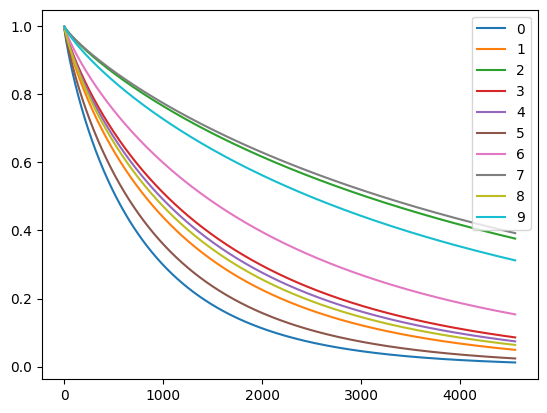

In [8]:
aft.predict_survival_function(x_test.iloc[:10]).plot()

#### **RSF**

In [9]:
# Train - Create a structured array
y_train = np.array([(x, y) for x, y in zip(x_train['death'].astype('bool') , x_train['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Test - Create a structured array
y_test = np.array([(x, y) for x, y in zip(x_test['death'].astype('bool') , x_test['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Val - Create a structured array
y_val = np.array([(x, y) for x, y in zip(x_val['death'].astype('bool') , x_val['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])


In [10]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234, oob_score = True
)
rsf.fit(x_train.iloc[: , :-2], y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, oob_score=True,
                     random_state=1234)

In [11]:
# Concordance
rsf.score(x_test.iloc[: , :-2], y_test) , rsf.score(x_val.iloc[: , :-2], y_val)

(0.662709482411599, 0.6905908696696049)

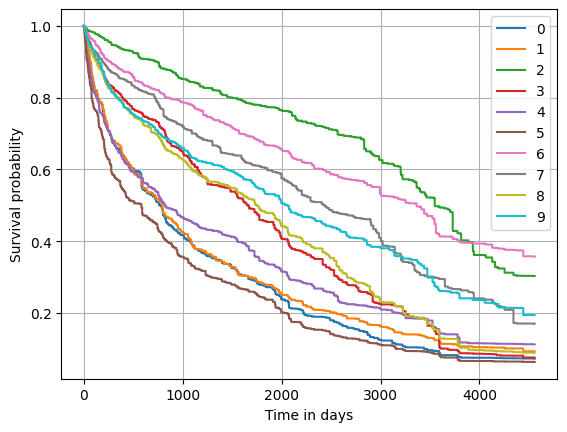

In [36]:
surv_10 = rsf.predict_survival_function(x_test.iloc[: , :-2][:10], return_array=True)

for i, s in enumerate(surv_10):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

shapes : (1035, 1035, 1035, 1035)
td-concordance 0.6770033686678578
integrated brier score 0.19552968914772603


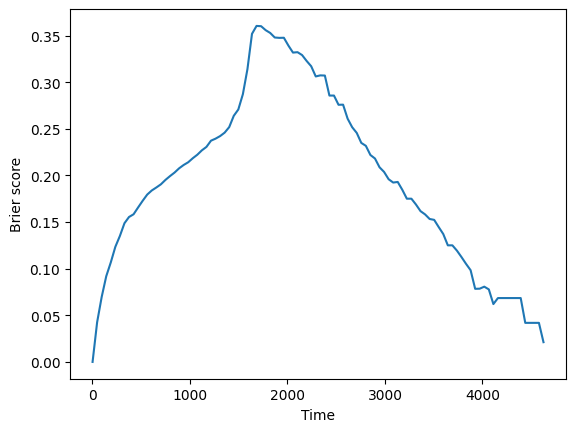

In [41]:
## td-concordance

# surv_rsf = rsf.predict_survival_function(x_test.iloc[: , :-2], return_array=True)

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_rsf.T), durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **PyCox**

0:	[0s / 0s],		train_loss: 1.7516,	val_loss: 1.7029
1:	[0s / 0s],		train_loss: 1.6359,	val_loss: 1.6111
2:	[0s / 0s],		train_loss: 1.5355,	val_loss: 1.4983
3:	[0s / 0s],		train_loss: 1.3894,	val_loss: 1.3556
4:	[0s / 0s],		train_loss: 1.2531,	val_loss: 1.2179
5:	[0s / 0s],		train_loss: 1.0913,	val_loss: 1.0804
6:	[0s / 0s],		train_loss: 0.9798,	val_loss: 0.9752
7:	[0s / 0s],		train_loss: 0.8835,	val_loss: 0.8868
8:	[0s / 0s],		train_loss: 0.8315,	val_loss: 0.8520
9:	[0s / 0s],		train_loss: 0.7998,	val_loss: 0.8250
10:	[0s / 0s],		train_loss: 0.7800,	val_loss: 0.8133
11:	[0s / 0s],		train_loss: 0.7571,	val_loss: 0.8042
12:	[0s / 1s],		train_loss: 0.7492,	val_loss: 0.7933
13:	[0s / 1s],		train_loss: 0.7398,	val_loss: 0.7725
14:	[0s / 1s],		train_loss: 0.7228,	val_loss: 0.7825
15:	[0s / 1s],		train_loss: 0.7336,	val_loss: 0.7781
16:	[0s / 1s],		train_loss: 0.7175,	val_loss: 0.7749
17:	[0s / 1s],		train_loss: 0.7189,	val_loss: 0.7797
18:	[0s / 1s],		train_loss: 0.7188,	val_loss: 0.7825
19:

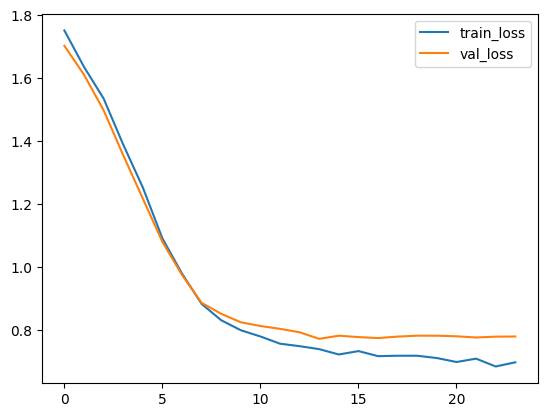

In [28]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

# one liner func
get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(x_train))
y_val = labtrans.transform(*get_target(x_val))

train = (x_train.iloc[: , :-2].to_numpy().astype('float32'), y_train)
val = (x_val.iloc[: , :-2].to_numpy().astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(x_test)

in_features = x_train.iloc[: , :-2].shape[1]
num_nodes = [32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.002), duration_index=labtrans.cuts)

batch_size = 256
epochs = 500
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train.iloc[:,:-2].to_numpy().astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

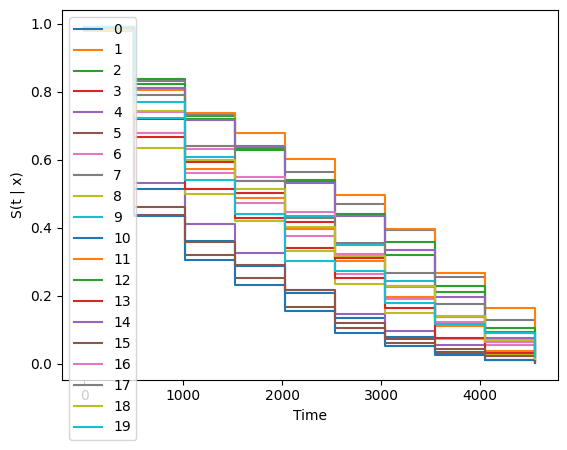

In [29]:
surv = model.predict_surv_df(x_test.iloc[: , :-2].to_numpy().astype('float32'))

surv.iloc[:, :20].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (1035, 1035, 1035, 1035)
td-concordance 0.5544671925649193
integrated brier score 0.16466082954282477


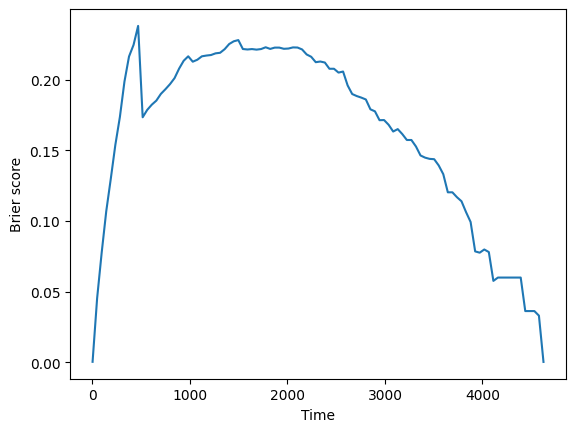

In [30]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

In [34]:
surv.shape , durations_test.shape , events_test.shape

((10, 1035), (1035,), (1035,))

#### **Deep Survival Machines**

In [86]:
import auton_survival
from auton_survival import datasets
from auton_survival.preprocessing import Preprocessor
from auton_survival.models.dsm import DeepSurvivalMachines
import numpy as np

horizons = [0.25, 0.5, 0.75]
times = np.quantile(consolidated_pat_tbl['time_to_event'].to_numpy()[consolidated_pat_tbl['death'].to_numpy()==1].max(), horizons).tolist()

param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [], [100], [100, 100] ]
             }

params = ParameterGrid(param_grid)

models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train.iloc[: , :-2].to_numpy(), x_train['time_to_event'].to_numpy(), x_train['death'].to_numpy() ,
              iters = 100 , 
              learning_rate = param['learning_rate']
            )
    models.append([[model.compute_nll(x_val.iloc[: , :-2].to_numpy(), x_val['time_to_event'].to_numpy(), x_val['death'].to_numpy()), 
                    model]])
best_model = min(models)
model = best_model[0][1]

  0%|          | 0/10000 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:01<00:13,  6.69it/s]


In [87]:
# Inference
out_risk = model.predict_risk(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)
out_survival = model.predict_survival(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)

cis = []
brs = []

e_train , e_test , e_val = x_train['death'].to_numpy() , x_test['death'].to_numpy() , x_val['death'].to_numpy()
t_train , t_test , t_val = x_train['time_to_event'].to_numpy() , x_test['time_to_event'].to_numpy() , x_val['time_to_event'].to_numpy()

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
# roc_auc = []
# for i, _ in enumerate(times):
#     roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
# for horizon in enumerate(horizons):
#     print(f"For {horizon[1]} quantile,")
#     print("TD Concordance Index:", cis[horizon[0]])
#     print("Brier Score:", brs[0][horizon[0]])
#     print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

ValueError: all times must be within follow-up time of test data: [1.0; 4626.0[

In [81]:
# times
x_test['time_to_event'].to_numpy().max()

4626.0

In [85]:
consolidated_pat_tbl['time_to_event'].to_numpy()[consolidated_pat_tbl['death'].to_numpy()==1].max()

4626.0

#### **DeepSurv**